In [1]:
%matplotlib inline

import os
import glob
import hdf5_getters
import pickle
import itertools
import numpy as np
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn import datasets
import random
from sklearn.cluster import MiniBatchKMeans
random.seed(3222)
np.random.seed(3222)

## Load data

In [2]:
def get_data(basedir, function, upto=10000, ext='.h5'):
    data = []
    count = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            if count == upto:
                return data
            if count%100 == 0:
                print count,
            h5 = hdf5_getters.open_h5_file_read(f)
            data.append(function(h5))
            h5.close()
            count += 1
    return data

# save as pickle to save time in loading
segments_pitches_1000 = get_data('../MillionSongSubset/data', hdf5_getters.get_segments_pitches, upto=200)
pickle.dump(segments_pitches_1000, open("../MillionSongSubset/pitches1000", "wb"))

0 100


In [69]:
segments_pitches_1000

[array([[ 0.172,  0.084,  0.086, ...,  0.072,  0.675,  1.   ],
        [ 0.078,  0.093,  0.074, ...,  0.047,  0.081,  0.153],
        [ 0.079,  0.049,  0.032, ...,  0.77 ,  1.   ,  0.245],
        ..., 
        [ 0.283,  0.627,  0.501, ...,  0.222,  0.264,  0.147],
        [ 1.   ,  0.425,  0.623, ...,  0.542,  0.43 ,  0.592],
        [ 0.347,  0.358,  0.493, ...,  0.642,  0.988,  0.524]]),
 array([[ 0.256,  0.296,  0.19 , ...,  0.18 ,  0.236,  1.   ],
        [ 1.   ,  0.798,  0.316, ...,  0.214,  0.292,  0.66 ],
        [ 0.29 ,  0.099,  0.073, ...,  0.077,  0.089,  1.   ],
        ..., 
        [ 0.834,  0.97 ,  0.658, ...,  0.678,  0.757,  0.974],
        [ 0.177,  0.314,  0.712, ...,  1.   ,  0.312,  0.294],
        [ 0.444,  0.347,  0.282, ...,  0.486,  0.697,  0.841]]),
 array([[ 0.138,  0.079,  0.109, ...,  0.306,  1.   ,  0.33 ],
        [ 0.119,  0.069,  0.066, ...,  0.219,  1.   ,  0.187],
        [ 0.057,  0.055,  0.059, ...,  0.158,  1.   ,  0.109],
        ..., 
        [

## squeeze vocab data into one array

In [3]:
# use first 100 songs to create vocabulary
vocab_size = 100
def build_set(data):
    num_of_items = 0
    for i in range(len(data)):
        num_of_items += data[i].shape[0]
    print num_of_items
    results = np.ndarray((num_of_items, data[0].shape[1]))
    count = 0
    for i in range(len(data)):
        for j in range(data[i].shape[0]):
            results[count] = data[i][j]
            count += 1
    return results
print "building vocab set"
vocab_pitches = build_set(segments_pitches_1000[:100])
print vocab_pitches.shape

building vocab set
91912
(91912, 12)


## old k-means code

In [55]:
from sklearn.utils.extmath import row_norms

In [80]:
def assign_points_to_labels(centroids, points):
    # 1 list for each centroid (will contain indices of points)
    k = len(centroids)
    labels = np.zeros(points.shape[0], dtype=int)
    dists = euclidean_distances(points, centroids)
    for i in range(points.shape[0]):
        # find nearest centroid to this point
        best_centroid = 0
        best_distance = dists[i, best_centroid]
        for c in range(1, k):
            distance = dists[i, c]
            if distance < best_distance:
                best_distance = distance
                best_centroid = c
        labels[i] = best_centroid
    return labels

def update_centroids(centroids, labels, points):
    k = len(centroids)
    n,d = points.shape[0], points.shape[1]
    sum_points = np.zeros([k, d])
    n_elements = np.zeros(k, dtype=int)
    for i in range(n):
        sum_points[labels[i]] += points[i]
        n_elements[labels[i]] += 1
    for ci in range(k):
        if n_elements[ci] != 0:
            centroids[ci] = sum_points[ci]/n_elements[ci]

def mykmeans(points, k, max_iter=50, centroids=None):
    n_samples, n_features = points.shape
    if not centroids:
        centroids = [points[x] for x in random.sample(range(n_samples), k)]
    labels = None
    for p in range(max_iter):
        labels = assign_points_to_labels(centroids, points)
        update_centroids(centroids, labels, points)
    return centroids, labels

        
def mykmeansplusplus(points, k, max_iter=50):
    n_samples, n_features = points.shape
    centroidIndices = []
    centroidIndices.append(np.random.randint(0, n_samples))
    for i in range(k-1):
        weightProb = []
        leftPointsIndices = [p for p in range(n_samples) if p not in centroidIndices]
        dists = euclidean_distances(points[leftPointsIndices], points[centroidIndices])
        for p in range(len(leftPointsIndices)):
            best_D = dists[p, 0]
            best_p = centroidIndices[0]
            for c in range(1, len(centroidIndices)):
                D = dists[p, c]
                if D < best_D:
                    best_D = D
            weightProb.append(best_D)
        cum = sum(weightProb)
        weightProb = [p/cum for p in weightProb]
        centroidIndices.append(np.random.choice(leftPointsIndices, p=weightProb))
    centroids = [points[c] for c in centroidIndices]
    print centroids
    return mykmeans(points, k, max_iter, centroids)
    

## learnvocabulary function

In [85]:
k = 64
def learnvocabulary(vocab_data, num_clusters, max_iter=50):
    return mykmeans(vocab_data, num_clusters, max_iter)
%time centroids, clusters = learnvocabulary(vocab_pitches, k, 50)
print centroids

CPU times: user 1min 18s, sys: 777 ms, total: 1min 19s
Wall time: 1min 18s
[array([ 0.66763231,  0.94665769,  0.71136231,  0.71635154,  0.49156846,
        0.40798231,  0.22635077,  0.19734692,  0.16042308,  0.16009385,
        0.20871231,  0.20103615]), array([ 0.47136169,  0.76905405,  0.91911844,  0.49291335,  0.42016773,
        0.37027266,  0.39930763,  0.37823688,  0.42187758,  0.67995787,
        0.44815103,  0.37245151]), array([ 0.73558148,  0.98335053,  0.19841208,  0.10860668,  0.09240152,
        0.09668757,  0.07685053,  0.08877198,  0.09143259,  0.07896659,
        0.11275615,  0.16033529]), array([ 0.31487024,  0.26209868,  0.17270474,  0.17062005,  0.31743901,
        0.29916239,  0.63731779,  0.66786558,  0.91509402,  0.95778089,
        0.64344289,  0.13246154]), array([ 0.38461625,  0.38650514,  0.29823249,  0.5136676 ,  0.40197479,
        0.29930065,  0.28429692,  0.38083754,  0.98660504,  0.39220635,
        0.24596265,  0.30066013]), array([ 0.34230944,  0.430648

## Bag of features

In [95]:
def getbof(centroids, signal):
    bof_tf = np.zeros(len(centroids))
    labels = assign_points_to_labels(centroids, signal)
    for i in range(labels.shape[0]):
        bof_tf[labels[i]] += 1
    return bof_tf/signal.shape[0]
# test on one example
print getbof(centroids, segments_pitches_1000[199])

[ 0.01253918  0.00208986  0.01358412  0.00208986  0.01462905  0.00626959
  0.          0.0031348   0.01567398  0.0031348   0.00731452  0.0031348
  0.00522466  0.00104493  0.00208986  0.          0.0031348   0.01462905
  0.00104493  0.0031348   0.01149425  0.00835946  0.00940439  0.00208986
  0.00835946  0.01671891  0.00731452  0.          0.          0.00104493
  0.00417973  0.00731452  0.          0.00417973  0.00522466  0.00208986
  0.00417973  0.00417973  0.00104493  0.01253918  0.00208986  0.00731452
  0.00208986  0.00522466  0.00104493  0.0292581   0.00835946  0.00417973
  0.0031348   0.00104493  0.0031348   0.00208986  0.0292581   0.00208986
  0.01462905  0.03448276  0.00208986  0.00940439  0.          0.00940439
  0.05433647  0.00417973  0.03970742  0.00104493  0.00208986  0.01358412
  0.00104493  0.00522466  0.01985371  0.00208986  0.00208986  0.00940439
  0.00104493  0.          0.00104493  0.02403344  0.01462905  0.00626959
  0.00208986  0.00208986  0.00626959  0.00208986  0.

## 3.1 Minibatch k-means

In [86]:
def cache_nearest_centroids(centroids, points, k):
    points_to_clusters = [-1 for i in range(len(points))]
    dists = euclidean_distances(centroids, points)
    for i in range(len(points)):
        # find nearest centroid to this point
        best_centroid = 0
        best_distance = dists[best_centroid, i]
        for c in range(1, k):
            distance = dists[c, i]
            if distance < best_distance:
                best_distance = distance
                best_centroid = c
        points_to_clusters[i] = best_centroid
    return points_to_clusters

def minibatch_kmeans(X, k, b, max_iter=300, C=None):
    n_samples, n_features = X.shape
    if not C:
        C = [X[c] for c in random.sample(xrange(n_samples), k)]
    
    for i in xrange(max_iter):
        v = [0 for i in xrange(k)]
        M = [X[j] for j in random.sample(xrange(n_samples), b)]
        d = cache_nearest_centroids(C, M, k)
        for j in range(len(M)):
            c = C[d[j]]
            v[d[j]] += 1
            eta = 1./v[d[j]]
            C[d[j]] = (1-eta)*c + eta*M[j]
    return C

In [90]:
k = 128
%time centroids = minibatch_kmeans(vocab_pitches, k, 1000)
print centroids

CPU times: user 10.2 s, sys: 31.9 ms, total: 10.2 s
Wall time: 10.2 s
[array([ 0.732   ,  0.803875,  0.8735  ,  0.694875,  0.674   ,  0.621   ,
        0.744125,  0.666125,  0.747125,  0.738875,  0.73475 ,  0.723   ]), array([ 0.49277778,  0.60588889,  0.26411111,  0.16077778,  0.19177778,
        0.35788889,  0.87677778,  0.94688889,  0.30811111,  0.29755556,
        0.24955556,  0.24144444]), array([ 0.09316667,  0.42316667,  0.43416667,  0.50683333,  0.98233333,
        0.88233333,  0.59733333,  0.54033333,  0.09183333,  0.08433333,
        0.04633333,  0.046     ]), array([ 1.        ,  0.86866667,  0.77966667,  0.68366667,  0.46633333,
        0.268     ,  0.338     ,  0.73133333,  0.523     ,  0.49033333,
        0.68433333,  0.426     ]), array([ 0.28411111,  0.22488889,  0.20611111,  0.525     ,  0.37211111,
        0.24588889,  0.189     ,  0.24033333,  1.        ,  0.31411111,
        0.14755556,  0.22877778]), array([ 1.    ,  0.2803,  0.3465,  0.3413,  0.2911,  0.2108,  0.2

## 3.2 Vector of locally aggregated descriptors (vlad)

In [57]:
def vlad(centroids, signal):
    # signal = variable, d 
    # centroids = k, d
    k = len(centroids)
    d = signal.shape[1]
    v = np.zeros([k, d])
    t = time.time()
    labels = assign_points_to_labels(centroids, signal)
    print time.time()-t
    # predicted_clusters contains indices of descriptors in signal belonging to different centroids. 
    for i in range(labels.shape[0]):
            v[labels[i]] += signal[i] - centroids[labels[i]]
    # Global L2 normalization
    n_v = v.reshape(k*d)
    n_v = n_v/np.sqrt(n_v.dot(n_v))
    return n_v

In [8]:
from sklearn.metrics.pairwise import euclidean_distances

In [15]:
euclidean_distances(segments_pitches_1000[199],centroids).shape

(957, 64)

In [68]:
segments_pitches_1000[np.array([2,4,5],dtype=int)]

TypeError: only integer arrays with one element can be converted to an index

In [10]:
# test vlad on example
ex = segments_pitches_1000[197]
%time v = vlad(centroids, ex)
print v.shape

CPU times: user 3.54 s, sys: 84.5 ms, total: 3.63 s
Wall time: 3.56 s
(768,)


In [11]:
# Use PCA to reduce dimensionality
# Use LSHForest for approximate nearest neighbors

In [12]:
X = segments_pitches_1000[100:200]
v = np.ndarray([100, 64*12])
t1 = time.time()
for i in range(len(X)):
    v[i] = vlad(centroids, segments_pitches_1000[i])
print time.time() - t1, 'secs'

141.704943895 secs


In [13]:
# reduce dimensionality to 50
pca = PCA(n_components=50)
%time new_v = pca.fit_transform(v)
print new_v.shape

CPU times: user 16.1 ms, sys: 8 ms, total: 24.1 ms
Wall time: 192 ms
(100, 50)


In [36]:
kmeans = MiniBatchKMeans(n_clusters=64)
%time kmeans.fit(vocab_pitches)

CPU times: user 2.71 s, sys: 3.91 ms, total: 2.72 s
Wall time: 2.72 s


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=64,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [15]:
vocab_pitches.shape

(91912, 12)

In [32]:
kmeans.cluster_centers_.shape

(32, 12)

In [19]:
kmeans.labels_

array([14,  8,  5, ...,  3, 14, 14], dtype=int32)

In [20]:
kmeans.labels_.shape

(91912,)

In [28]:
kmeans.labels_[50000]

22

In [44]:
kmeans.predict(segments_pitches_1000[102]);

In [30]:
segments_pitches_1000[100].shape

(449, 12)

In [34]:
np.set_printoptions(threshold=np.nan)

In [37]:
# test vlad on example
ex = segments_pitches_1000[197]
%time v1 = vlad(centroids, ex)
print v1.shape
%time v2 = vlad2(ex, kmeans)
print v2.shape

0.0352399349213
CPU times: user 41.6 ms, sys: 10 µs, total: 41.6 ms
Wall time: 41.1 ms
(768,)
CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 16.5 ms
(768,)


In [46]:
v1;

In [47]:
v2;

[[  5.   3.   2.   2.   3.   1.   3.   6.   3.   2.   4.   3.   3.   5.
    1.   2.   1.   2.   2.   3.]
 [  4.   2.   3.   2.   1.   4.   2.   4.   2.   2.   3.   2.   0.   7.
    4.   3.   3.   5.   2.   1.]
 [  0.   0.   3.   5.   8.   3.   3.   1.   3.   1.   2.   2.   0.   3.
    0.   4.   1.   2.   4.   3.]
 [  4.   0.   1.   2.   3.   6.   2.   5.   1.   5.   2.   3.   0.   1.
    2.   2.   0.   3.   4.   4.]
 [  0.   2.   3.   2.   1.   2.   0.   2.   1.   4.   1.   3.   1.   1.
    1.   2.   2.   4.   0.   2.]
 [  1.   2.   2.   1.   3.   3.   2.   3.   4.   1.   3.   2.   3.   1.
    3.   0.   4.   3.   4.   1.]
 [  0.   1.   0.   4.   1.   0.   0.   3.   0.   7.   2.   9.   0.   1.
    2.   7.   5.   4.   0.   8.]
 [  1.   2.   2.   0.   0.   2.   3.   3.   1.   1.   1.   4.   2.   4.
    0.   3.   3.   2.   4.   6.]
 [  4.   7.   3.   3.   3.   1.   3.   5.   1.   1.   1.   3.   2.   3.
    0.   1.   1.   1.   5.   1.]
 [  0.   0.   1.   3.   7.   7.   1.   2.   3.   6.   3

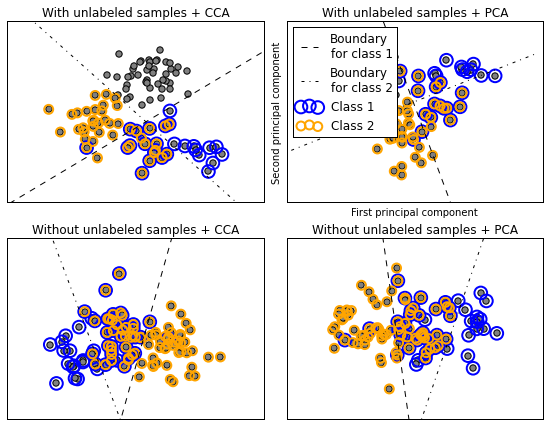

In [53]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA


def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel='linear'))
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
               facecolors='none', linewidths=2, label='Class 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
               facecolors='none', linewidths=2, label='Class 2')

    plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
                    'Boundary\nfor class 1')
    plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k-.',
                    'Boundary\nfor class 2')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(loc="upper left")


plt.figure(figsize=(8, 6))

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=True,
                                      random_state=1)
print X
print Y
plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=False,
                                      random_state=1)

plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

plt.subplots_adjust(.04, .02, .97, .94, .09, .2)


In [56]:
a = np.random.rand(100)

In [58]:
b = np.random.rand(100)

In [59]:
%time euclidean(a,b)

CPU times: user 702 µs, sys: 4 µs, total: 706 µs
Wall time: 50.5 ms


4.065469531638643

In [62]:
def dist(a,b):
    return np.sqrt(np.dot(a, a) - 2 * np.dot(a, b) + np.dot(b, b))

In [96]:
a = np.zeros([2,9])

In [97]:
b = np.zeros([2,10])

In [99]:
np.hstack([a,b]).shape

(2, 19)